In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchinfo import summary
import torch.optim as optim

import matplotlib.pyplot as plt
from timeit import default_timer as timer

import numpy as np

random_seed = 1
torch.manual_seed(random_seed)
np.random.seed(random_seed)

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

trainset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=ToTensor()
)
validationset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=ToTensor()
)
testset = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=ToTensor()
)
classes = trainset.classes

valid_size = 0.2
train_length = len(trainset)
indices = list(range(len(trainset)))
split = int(np.floor(valid_size * train_length))

np.random.shuffle(indices)

train_idx=indices[split:]
valid_idx=indices[:split]
train_sampler=SubsetRandomSampler(train_idx)
validation_sampler=SubsetRandomSampler(valid_idx)

batch_size = 256
train_loader = DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(trainset, batch_size=batch_size, sampler=validation_sampler)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

print(f"Length of train data loader: {len(train_loader)} batches of {batch_size}")
print(f"Length of validation data loader: {len(valid_loader)} batches of {batch_size}")
print(f"Length of test data loader: {len(test_loader)} batches of {batch_size}")

train_features_batch, train_label_batch = next(iter(train_loader))
print(train_features_batch.shape, train_label_batch.shape)

Length of train data loader: 188 batches of 256
Length of validation data loader: 47 batches of 256
Length of test data loader: 40 batches of 256
torch.Size([256, 1, 28, 28]) torch.Size([256])


In [2]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

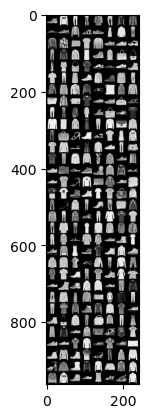

In [3]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

In [4]:
import seaborn as sns

class ConvModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(ConvModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3,stride = 1,padding = 1)
        self.fc1 = nn.Linear(in_features= 64*14*14,out_features=32)
        self.fc2 = nn.Linear(in_features = 32, out_features=10)
        self.dropout = nn.Dropout(0.2)
        self.maxpool = nn.MaxPool2d(kernel_size= 3,stride = 2,padding=1)
        
    def forward(self, x):
        
        x = torch.relu(self.conv1(x))
        x = self.maxpool(x)
        x = x.view(x.size(0),-1)
        x = self.dropout(x)
        x = self.fc2(torch.relu(self.fc1(x)))
        return x

In [5]:
def train_step(model, train_loader, loss_fn, optimizer, reg_param, device):
    
    model.train()
    full_acc = 0.0
    full_loss = 0.0
    
    for i, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss_hat = loss_fn(output, target)
        
        reg_L2_norm = 0.0
        for param in model.parameters():
            reg_L2_norm += torch.norm(param, p=2)**2 

        temp_loss = loss_hat + reg_param * reg_L2_norm
        optimizer.zero_grad()
        loss_hat.backward()
        optimizer.step()
        
        _, predicted = torch.max(output, 1)
        temp_acc = (predicted == target).float().mean()
        full_loss += temp_loss.item()
        full_acc += temp_acc.item()
    
    length = len(train_loader)
    average_full_loss = full_loss / length
    average_full_acc = full_acc / length
    
    return average_full_acc, average_full_loss

In [6]:
def evaluation_step(model, data_loader, loss_fn, reg_param, device):
    
    model.eval()
    length = 0
    full_loss = 0.0
    final_correct = 0
    
    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            temp_loss = loss_fn(outputs, labels)
            full_loss += temp_loss.item() * data.size(0) 

            _, predictions = torch.max(outputs, 1)
            final_correct += (predictions == labels).sum().item()
            length += data.size(0)
    
    acc = final_correct / length
    average_full_loss = full_loss / length
    
    return acc, average_full_loss

In [7]:
def train_conv_model(train_loader, valid_loader, test_loader, random_seed):
    
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
    else:
        if torch.backends.mps.is_available():
            device = "mps"

    torch.manual_seed(random_seed)

    
    model = ConvModel(train_features_batch.shape[0], train_label_batch).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    loss_func = nn.CrossEntropyLoss()
    param_r = 0.00001
    
    train_acc_out, v_acc_out, test_acc_out, train_loss_out, v_loss_out, test_loss_out = [], [],[], [], [], []
    
    ne_s = 15
    for e in range(ne_s):
        model.train()
        train_acc, train_loss = train_step(model, train_loader, loss_func, optimizer, param_r, device)
        train_loss_out.append(train_loss)
        train_acc_out.append(train_acc)

        model.eval()
        valid_acc, valid_loss = evaluation_step(model, valid_loader, loss_func, param_r, device)
        v_loss_out.append(valid_loss)
        v_acc_out.append(valid_acc)
        
        test_acc, test_loss = evaluation_step(model, test_loader, loss_func, param_r, device)
        test_loss_out.append(test_loss)
        test_acc_out.append(test_acc)
        
        print("Epoch", e+1)
        print("Train acc:", train_acc, "Train loss:", train_loss)
        print("Validation acc:", valid_acc, "Validation Loss:", valid_loss)
        print("Test acc:", test_acc, "Test Loss:", test_loss)
        print("="*75)

    return model, train_loss_out, train_acc_out, v_loss_out, v_acc_out, test_loss_out, test_acc_out

In [8]:
def plot_accuracy_performance(train_accuracies, valid_accuracies, test_accuracies):

    sns.lineplot(train_accuracies, label = 'Train')
    sns.lineplot(valid_accuracies, label = "Validation")
    sns.lineplot(test_accuracies, label = 'Test')
    plt.title('Accuracy over time')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(0, 15))
    plt.legend()
    plt.show()

In [9]:
def plot_loss_performance(train_losses, valid_accuracies, test_losses):

    sns.lineplot(train_losses, label = 'Train')
    sns.lineplot(valid_losses, label = "Validation")
    sns.lineplot(test_losses, label = 'Test')
    plt.title('Loss over time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(np.arange(0, 15))
    plt.legend()
    plt.show()

In [10]:
random_seed = 1
model, train_losses, train_accuracies, valid_losses, valid_accuracies, test_losses, test_accuracies\
= train_conv_model(train_loader, valid_loader, test_loader, random_seed)

Epoch 1
Train acc: 0.763193982712766 Train loss: 0.6805362769580902
Validation acc: 0.8463333333333334 Validation Loss: 0.4299772895971934
Test acc: 0.8396 Test Loss: 0.44836396594047545
Epoch 2
Train acc: 0.8624501329787234 Train loss: 0.39462553781080756
Validation acc: 0.8719166666666667 Validation Loss: 0.360235648393631
Test acc: 0.8634 Test Loss: 0.3840248497724533
Epoch 3
Train acc: 0.8804853723404256 Train loss: 0.34408310063658876
Validation acc: 0.8790833333333333 Validation Loss: 0.3358373828728994
Test acc: 0.8706 Test Loss: 0.3588387614250183
Epoch 4
Train acc: 0.8889627659574468 Train loss: 0.31940290109908326
Validation acc: 0.8859166666666667 Validation Loss: 0.3178981193701426
Test acc: 0.8807 Test Loss: 0.3374213437795639
Epoch 5
Train acc: 0.8964635970744681 Train loss: 0.2984906977161448
Validation acc: 0.8905 Validation Loss: 0.3025777701536814
Test acc: 0.8859 Test Loss: 0.3221711636781692
Epoch 6
Train acc: 0.8999542885638298 Train loss: 0.2862257291661932
Valida

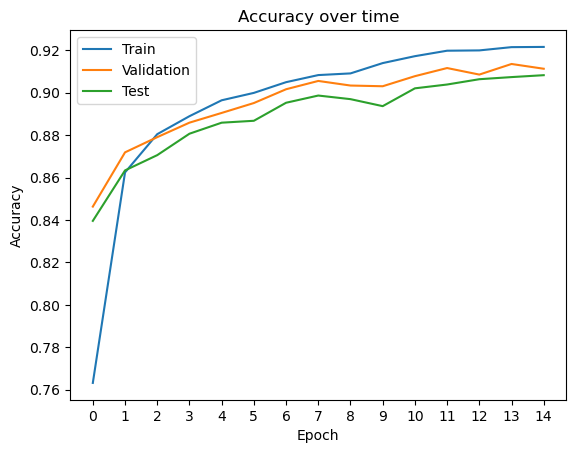

In [11]:
plot_accuracy_performance(train_accuracies, valid_accuracies, test_accuracies)

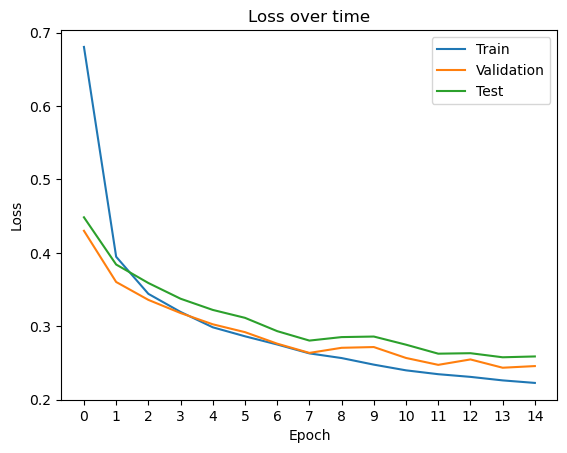

In [12]:
plot_loss_performance(train_losses, valid_losses, test_losses)